In [19]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nibabel as nib
import scipy.io
import time
import pandas as pd
import glob
import re
import os
import sys

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
from scipy.io import loadmat
import scipy.ndimage
import scipy.linalg

import torch
import torch.nn as nn

In [23]:
import h5py

data_path = '../PaulTrainData/3DMRSIMAP_Vol_04_A_1_2024-09-06_L2_0p0005/TESTING_beforeLipid.mat'

with h5py.File(data_path, 'r') as f:
    print(list(f.keys()))  # to see what variables are stored

    # Example: Load a variable named 'X'
    mask = f['mask'][:]
    #data = f['csi'][:]
print(mask.shape)

['#refs#', 'CoilCombtic', 'Concept_flag', 'CurAvg', 'FastPIReprocess_flag', 'NoOfPseudoReplicas', 'NoOfTempInterleaves', 'NoOfTempInterleaves_vec', 'NoiseCorrMat_post', 'Noise_CorrMat', 'Noise_mat', 'NumberOfLoopsPerSlice', 'Par', 'ReadInInfo', 'SettingsInfo', 'ans', 'conj_flag', 'csi', 'csi_k_backup', 'csi_k_p', 'dummyfilter', 'fid_mask', 'i', 'image', 'image_k_p', 'isStackofRings', 'kreiserl', 'mask', 'mask_BefInterpol', 'mask_flag_parfor', 'nSlices', 'nc', 'noise_sim', 'post_grd_dc_flag', 'size_csi', 'size_csi_ForNoise', 'slicenmb', 'tmp_dir', 'totCoili', 'totCoili_parfor', 'true_weights']
(39, 64, 64)


In [15]:
p_cc = '../PaulTrainData/3DMRSIMAP_Vol_04_A_1_2024-09-06_L2_0p0005/CoilCombined.h5'
fh_cc = h5py.File(p_cc,'r')
csi_rrrt = np.array(fh_cc['csi_cc_rrrt'])

In [24]:
brainmask = mask
pad=3
ite=2
tmp = brainmask
tmp = np.pad(tmp, [(pad, pad), (pad, pad), (pad, pad)])
tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
brainmask += tmp[pad:-pad,pad:-pad,pad:-pad]
brainmask[brainmask>=1]=1

brainmask[:,:,:10]=0

In [31]:
### Brainmask ###
brainmask = np.transpose(mask, axes=(2,1,0))

pad=3
ite=2
tmp = brainmask
tmp = np.pad(tmp, [(pad, pad), (pad, pad), (pad, pad)])
tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
brainmask += tmp[pad:-pad,pad:-pad,pad:-pad]
brainmask[brainmask>=1]=1

brainmask[:,:,:10]=0



if False:
    nuisance_rrr = np.sum(np.abs(csi_rrrt), axis=-1)
    fig, ax = plt.subplots(8, 5, figsize=(10,20))
    for i in range(8):
        for ii in range(5):
            sl = i*5 + ii
            if sl<39:
                ax[i,ii].imshow(nuisance_rrr[:,:,sl], vmax=12570230000000)
                ax[i,ii].imshow(brainmask[:,:,sl], cmap='Reds', alpha=0.5)
    fig.tight_layout()
    plt.show()



### Headmask ###
nuisance_rrr = np.sum(np.abs(csi_rrrt), axis=-1)

x, y = np.indices((64, 64))
circ = (x-32)**2+(y-32)**2
thresh = 1000
circ[circ<=thresh]=1
circ[circ>thresh]=0

headmask = circ[:,:,None]*nuisance_rrr

thresh2 = 9*10**11
headmask[headmask<thresh2] = 0
headmask[headmask>=thresh2] = 1

pad=10
ite=8
for sl in range(39):
    tmp = headmask[:,:,sl]
    tmp = np.pad(tmp, [(pad, pad), (pad, pad)])
    tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
    tmp = scipy.ndimage.binary_erosion(tmp, iterations=ite)
    headmask[:,:,sl] += tmp[pad:-pad,pad:-pad]
headmask[headmask>=1]=1

pad=10
ite=8
tmp = headmask
tmp = np.pad(tmp, [(pad, pad), (pad, pad), (pad, pad)])
tmp = scipy.ndimage.binary_dilation(tmp, iterations=ite)
tmp = scipy.ndimage.binary_erosion(tmp, iterations=ite)
headmask += tmp[pad:-pad,pad:-pad,pad:-pad]
headmask[headmask>=1]=1

headmask[:,:,:10]=0

In [32]:
brainmask.shape

(64, 64, 39)

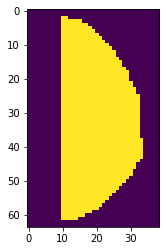

In [33]:
mask.shape

z = 20

plt.imshow(brainmask[z,:,:])

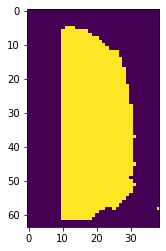

In [35]:
mask.shape

z = 20

plt.imshow(headmask[z,:,:])

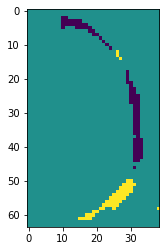

In [36]:
skmask = headmask - brainmask

mask.shape

z = 20

plt.imshow(skmask[z,:,:])

In [38]:
has_minus_one = np.any(skmask == -1)
print(has_minus_one) 

True


In [2]:
#!ls /ceph/mri.meduniwien.ac.at/departments/radiology/mrsbrain/home/lhingerl/DEEPCRTMRSI/results41/

out_path='/workspace/walinet/Removed42.h5'

In [3]:
fh = h5py.File(out_path)
print(fh.keys())

<KeysViewHDF5 ['csi_rrrt', 'data_rrrf', 'data_rrrt', 'lipPred_rrrf', 'waterRem_rrrt']>


In [4]:
input_rrrf = np.array(np.fft.fftshift(np.fft.fft(fh['csi_rrrt'], axis=-1), axes=-1))
out_rrrf = np.array(fh['data_rrrf'])
lipPred_rrrf = np.array(fh['lipPred_rrrf'])

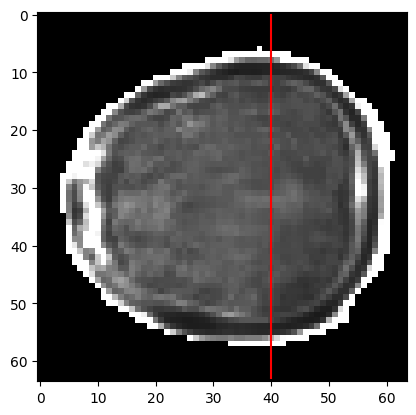

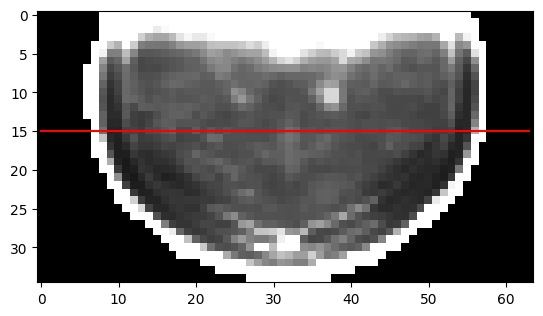

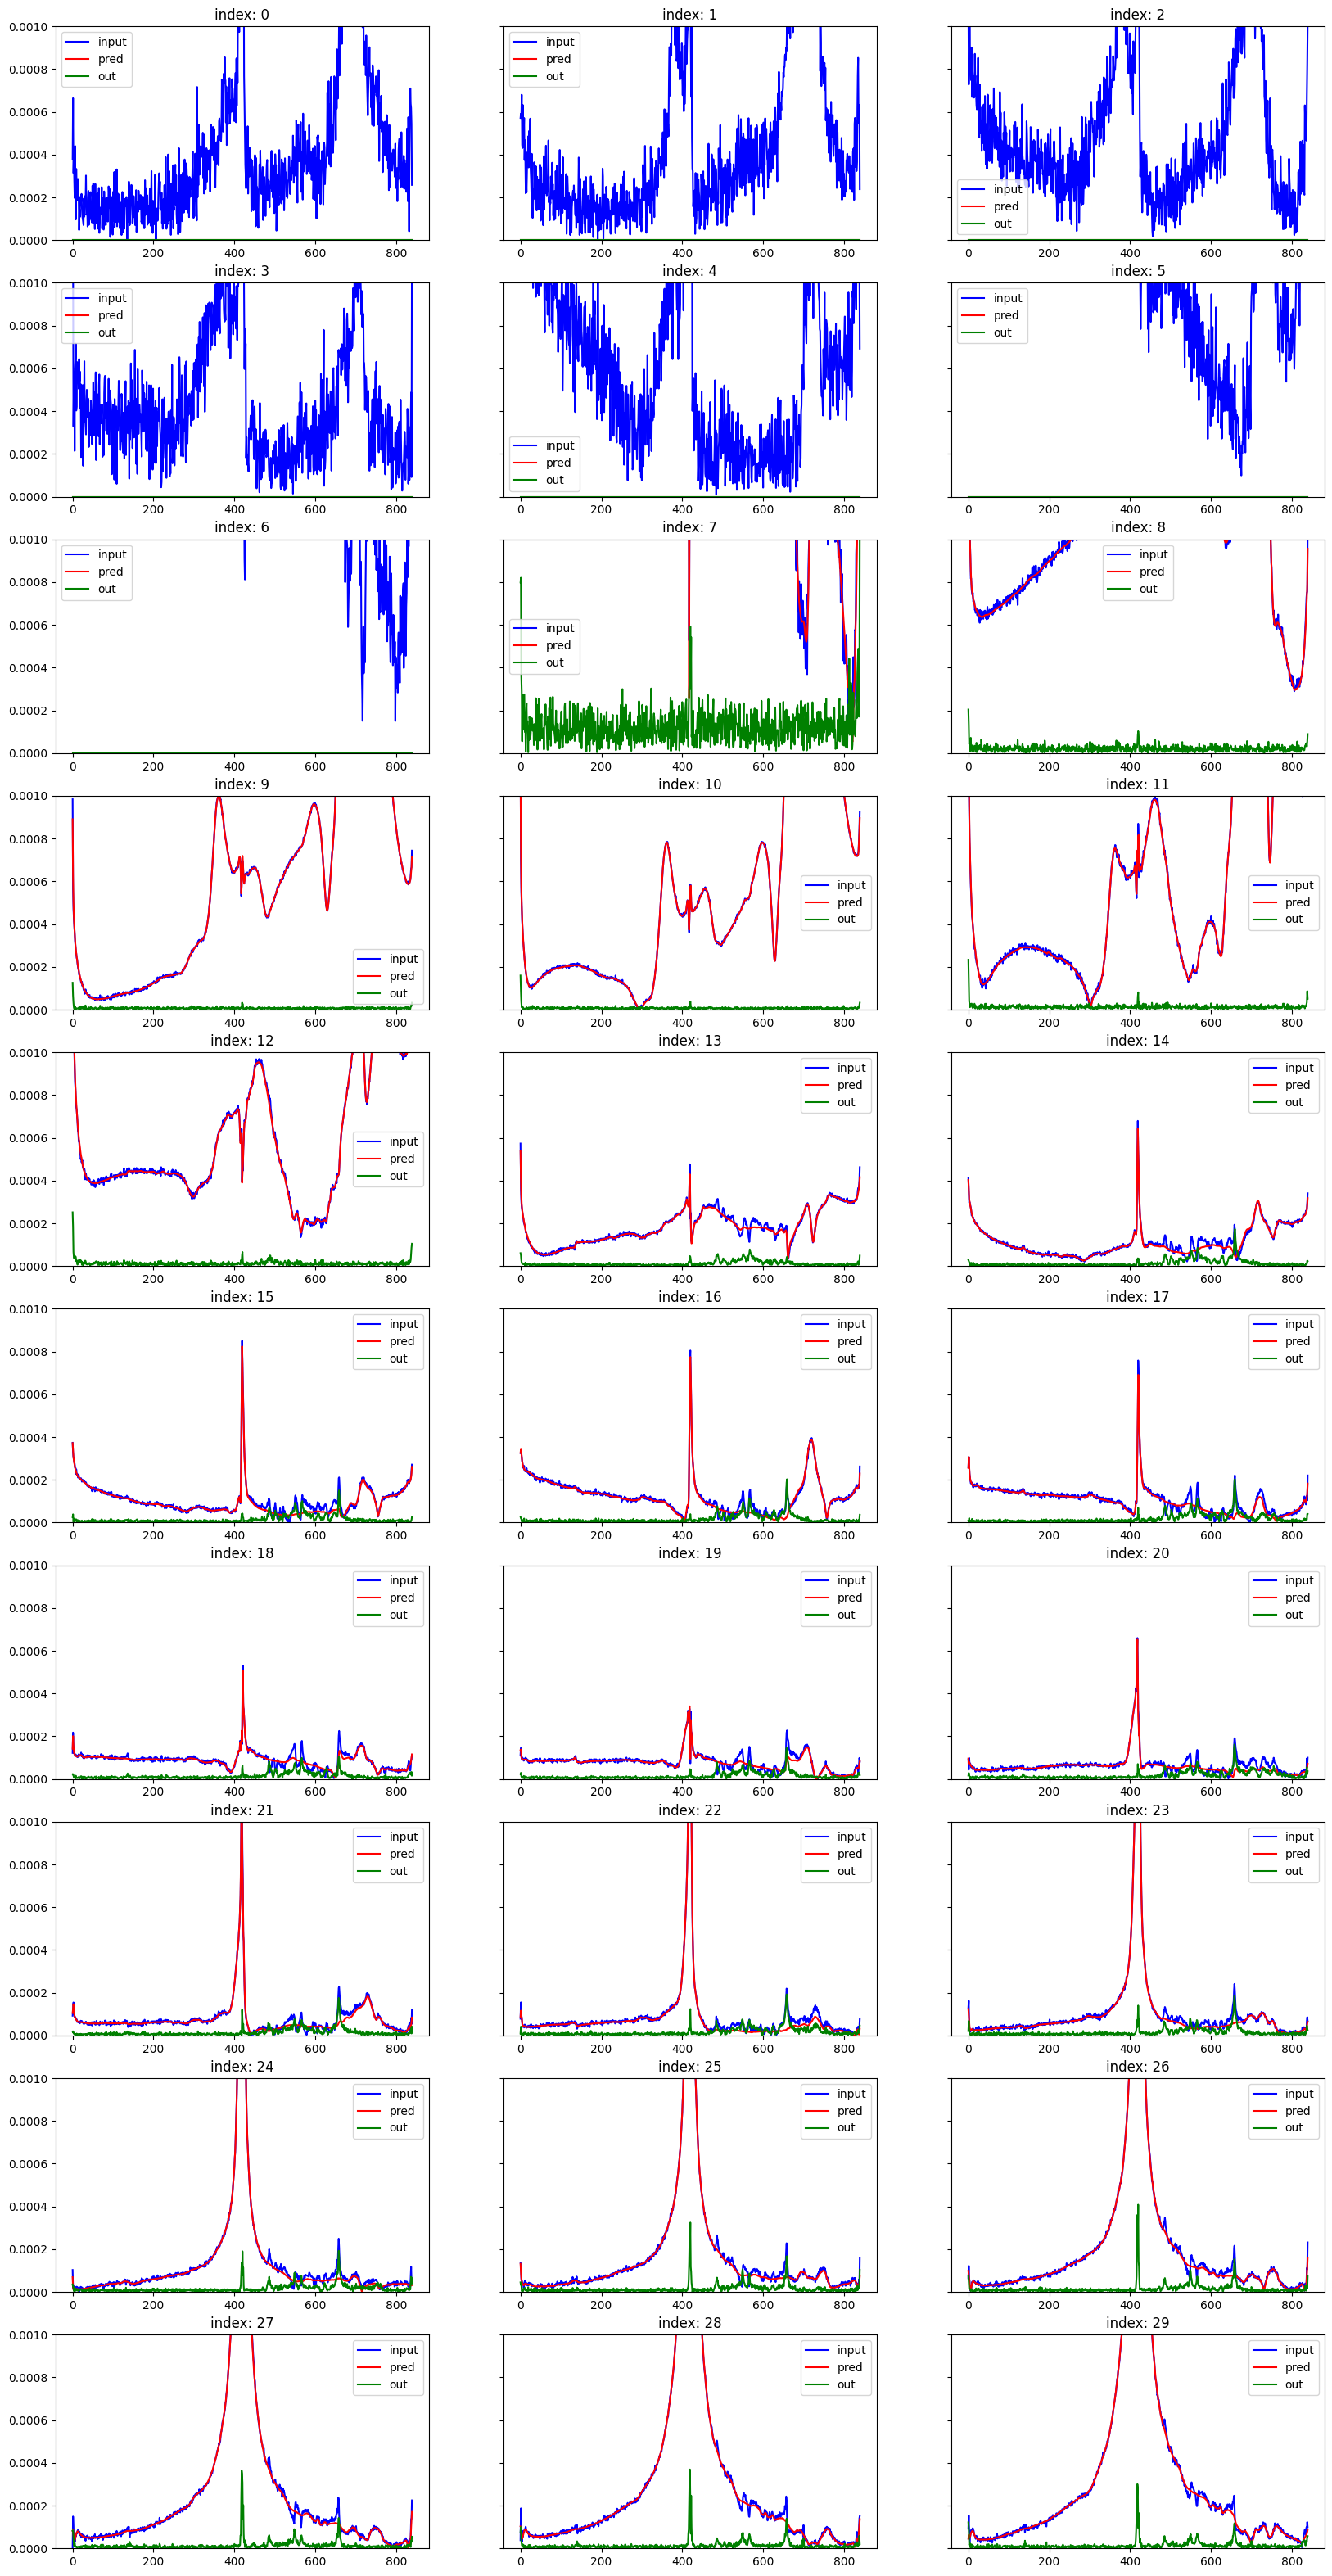

In [5]:
zdim=15
ydim=40#25

sum_img_grid = np.sum(np.abs(out_rrrf), axis=-1)


vmax=.04
plt.imshow(sum_img_grid[:,:,zdim], cmap="gray", vmax=vmax)
x = [ydim, ydim]
y = [0,63]
plt.plot(x,y,'red')
#plt.savefig("images/Subject"+sub+"_"+exp+"_brain")
plt.show()
plt.imshow(np.flip(np.rot90(sum_img_grid[:,ydim,:], k=3), axis=1), cmap="gray", vmax=vmax)
x = [0,63]
y = [zdim, zdim]
plt.plot(x,y,'red')
plt.show()

rows=10
winsz=4

fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(20,rows*winsz), sharey=True)
for i in range(rows):
    for ii in range(3):
        sl = i*3 + ii
        
        
        
        #fid2 = image_rrrt[sl,ydim,zdim,:]
        ##fid2 = imageNew_rrrt[sl,ydim,zdim,:]
        #fid2 = image_watersupp_rrrt[sl,ydim,zdim,:]
        #spec2 = np.fft.fftshift(np.fft.fft(fid2))
        #ax[i,ii].plot(np.abs(spec2), label='orig', color='green')
        spec1 = input_rrrf[sl,ydim,zdim,:]
        ax[i,ii].plot(np.abs(spec1), label='input', color='blue')
        spec2 = lipPred_rrrf[sl,ydim,zdim,:]
        ax[i,ii].plot(np.abs(spec2), label='pred', color='red')
        spec3 = out_rrrf[sl,ydim,zdim,:]
        ax[i,ii].plot(np.abs(spec3), label='out', color='green')
        ax[i,ii].set_ylim([0,0.001])
        
        
        #ax2 = ax[i,ii].twinx()
        #spec1 = Data_LipidRemoved_rrrf[sl,ydim,zdim,:]
        #spec3 = metab_rrrf[sl,ydim,zdim,:]
        #ax[i,ii].plot(np.abs(spec3), label='metab', color='red')
        #ax2.plot(np.abs(spec1), label='pred', color='orange')
        #ax2.set_ylim([0,7*1e11])
        #ax2.legend()
        ax[i,ii].title.set_text('index: ' + str(sl))
        ax[i,ii].legend()
        
        
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
#plt.savefig("images/Subject"+sub+"_"+exp+"_lipidrem")
plt.show()